# Faktorizacija matrik

Osnovni cilj faktorizacije je izraziti matriko X kot produkt dveh matrik nižjega reda (k):

    X ~ W * H

Pri čemer je:

    X reda (m, n)

    W reda (m, k)
    H reda (k, n)
    
Nižji red (k) predstavlja pričakovano število vzorcev v podatkih.

## Primer - ekspresija genov

<img src="http://127.0.0.1:8888/notebooks/slike/faktorizacija-primer.png", width=700>

Iščemo torej takšni matriki W in H, katerih produkt bo karseda dobro aproksimiral izvirni X.

X ~ X_app = W * H 

Začnimo s primerom (naključno generirani podatki X):

In [1]:
import numpy as np
G = np.random.rand(10, 2)
G

array([[ 0.21381082,  0.00948609],
       [ 0.77222321,  0.35733436],
       [ 0.03124893,  0.5519926 ],
       [ 0.83341421,  0.35948197],
       [ 0.78357   ,  0.11266154],
       [ 0.17109978,  0.07669748],
       [ 0.71735885,  0.94300482],
       [ 0.16732064,  0.26768403],
       [ 0.54822884,  0.93092406],
       [ 0.75105457,  0.48829814]])

In [2]:
X = G.dot(G.T)
X

array([[ 0.04580505,  0.16849939,  0.01191761,  0.18160306,  0.16860447,
         0.03731054,  0.16232451,  0.03831424,  0.12604809,  0.16521563],
       [ 0.16849939,  0.72401653,  0.22137707,  0.77203705,  0.64534879,
         0.15953387,  0.89092918,  0.22486158,  0.75600619,  0.75446748],
       [ 0.01191761,  0.22137707,  0.30567233,  0.22447469,  0.08667406,
         0.04768313,  0.54294838,  0.15298819,  0.53099476,  0.29300661],
       [ 0.18160306,  0.77203705,  0.22447469,  0.82380653,  0.69353817,
         0.17016835,  0.93685029,  0.23567498,  0.79155212,  0.80147393],
       [ 0.16860447,  0.64534879,  0.08667406,  0.69353817,  0.62667458,
         0.14270951,  0.66834126,  0.16126513,  0.53445501,  0.64351625],
       [ 0.03731054,  0.15953387,  0.04768313,  0.17016835,  0.14270951,
         0.03515764,  0.19506604,  0.04915922,  0.16520137,  0.16595651],
       [ 0.16232451,  0.89092918,  0.54294838,  0.93685029,  0.66834126,
         0.19506604,  1.40386181,  0.37245627

Kako torej določiti W in H, da bo X ~ W * H?

Začnimo z naključnima matrikama nižjega reda:

In [3]:
k = 2 # red faktorizacije, pričakovano število vzorcev v podatkih

m, n  = X.shape
W     = np.random.rand(m, k)
H     = np.random.rand(k, n)

In [4]:
W

array([[ 0.34933672,  0.06023433],
       [ 0.60606465,  0.67990942],
       [ 0.2972438 ,  0.56089648],
       [ 0.25393023,  0.25691046],
       [ 0.75965251,  0.02115036],
       [ 0.61711351,  0.51448533],
       [ 0.98833306,  0.84340659],
       [ 0.94017607,  0.98065244],
       [ 0.02479218,  0.76359887],
       [ 0.30903088,  0.65583998]])

In [5]:
H

array([[ 0.4763206 ,  0.28677701,  0.95133682,  0.87076167,  0.6754595 ,
         0.70104067,  0.86729464,  0.36462253,  0.88728992,  0.27155853],
       [ 0.52710875,  0.92365904,  0.90862696,  0.61327978,  0.89416723,
         0.2366802 ,  0.31938903,  0.15417188,  0.23323164,  0.12912498]])

Za posamezno celico [i, j] pogledamo odstopanje trenutne vrednosti celice v X_app od prave vrednosti celice v X.

In [6]:
X_app = W.dot(H)
dif = X - X_app
print "celica [0,0]:", X[0,0], X_app[0,0], dif[0,0]
print "celotna napaka:", np.sqrt(((dif**2).sum()))

celica [0,0]: 0.0458050543144 0.198146320435 -0.15234126612
celotna napaka: 5.20463549416


Postopno ju popravlja
mo z določenimi pravili.

Najprej ugotovimo razlike (napake):

In [7]:
dw = np.zeros((m, k))
dh = np.zeros((k, n))
for i, j in zip(*(X.nonzero())):
    for f in xrange(k):
        dw[i, f]    = dw[i, f] + (X[i, j] - W[i, :].dot(H[:, j])) * H[f, j]
        dh[f, j]    = dh[f, j] + (X[i, j] - W[i, :].dot(H[:, j])) * W[i, f]

Nato ustrezno popravimo matriki W in H:

In [8]:
eta = 0.02
W = W + eta * dw
H = H + eta * dh
W = W * (W > 0)
H = H * (H > 0)

Postopek ponavljamo dokler ni

X_app = W * H dovolj podobna pravemu X.

In [9]:
X_app = W.dot(H)
dif = X - X_app
print "celica [0,0]:", X[0,0], X_app[0,0], dif[0,0]
print "celotna napaka:", np.sqrt(((dif**2).sum()))

celica [0,0]: 0.0458050543144 0.159042814945 -0.113237760631
celotna napaka: 4.35424510542


# Algoritem za faktorizacijo - gradientni spust

In [10]:
from itertools import combinations, product
import numpy as np
import sys

def pgdnmf(X, rank, max_iter=100, tol=1e-5, eta=1e-2):
    """
        NMF using projected gradient descent.
        Minimize || X - WH ||_F, subject to W, H >= 0.

        :param X:
            Data matrix.
        :param rank
            Maximal rank of the model (W, H).
        :param max_iter
            Maximum number of iterations.

        :return
            Data model W, H.
    """
    m, n  = X.shape
    W     = np.random.rand(m, rank)
    H     = np.random.rand(rank, n)
    itr   = 0
    error = float("inf")

    known = X.nonzero()

    while error > tol and itr < max_iter:
        error = 0
        if itr % 10 == 0:
            sys.stdout.write("%s/%s\r" % (itr, max_iter))
            sys.stdout.flush()

        dw = np.zeros((m, rank))
        dh = np.zeros((rank, n))
        for i, j in zip(*known):
            for k in xrange(rank):
                dw[i, k]    = dw[i, k] + (X[i, j] - W[i, :].dot(H[:, j])) * H[k, j]
                dh[k, j]    = dh[k, j] + (X[i, j] - W[i, :].dot(H[:, j])) * W[i, k]       
            error += (X[i, j] - W[i, :].dot(H[:, j]))**2

        W = W + eta * dw
        H = H + eta * dh
        W = W * (W > 0)
        H = H * (H > 0)
        itr += 1

    return W, H

## Rezultat faktorizacije na prejšnjem primeru

In [11]:
W, H = pgdnmf(X, rank=3)

In [12]:
X_app = W.dot(H)
dif = X - X_app
print "celica [0,0]:", X[0,0], X_app[0,0], dif[0,0]
print "celotna napaka:", np.sqrt(((dif**2).sum()))
print np.linalg.norm(dif, ord="fro")

celica [0,0]: 0.0458050543144 0.00658480778938 0.0392202465251
celotna napaka: 0.73254455696
0.73254455696


## Katero vrednost k izbrati?

In [14]:
# koda se izvaja zelo dolgo časa (~10 min), predvsem zaradi notranje zanke
pts = []
for k in range(1, 20):
    # ponovimo večkrat, da se izognemo lokalnemu minimumu
    es = []
    for _ in range(25):
        W, H = pgdnmf(X, rank=k, max_iter=300)
        X_app = W.dot(H)
        e = np.linalg.norm(X - X_app, ord="fro")
        es.append(e)
    pts.append((k, es))

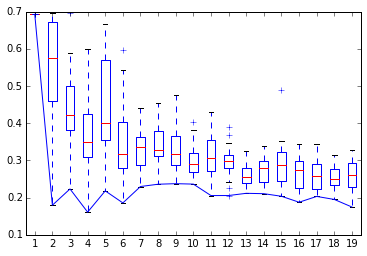

In [15]:
import pylab
%matplotlib inline

xs, ys = zip(*pts)
pylab.boxplot(ys, positions=xs)
pylab.plot(xs, np.amin(ys, axis=1));

## Realen primer - podatki iris

In [16]:
import Orange
data = Orange.data.Table("iris")
#imputer = Orange.feature.imputation.ModelConstructor()
#imputer.learner_continuous = Orange.regression.mean.MeanLearner()
#imputer.learner_discrete = Orange.classification.bayes.NaiveLearner()
#imputer = imputer(data)
#data = imputer(data)
X, c, _ = data.to_numpy()
print "Dimenzije tabel: X = %s, c = %s" % (X.shape, c.shape)

Dimenzije tabel: X = (150, 4), c = (150,)


Če podatkov preveč, vzemimo le podmnožico podatkov.

In [17]:
sub_i = sorted(np.random.choice(X.shape[0], 120, replace=False))
X = X[sub_i,:]
c = c[sub_i]
print "Dimenzije tabel: X = %s, c = %s" % (X.shape, c.shape)

Dimenzije tabel: X = (120, 4), c = (120,)


In [18]:
k = 2
W, H = pgdnmf(X, rank=k, max_iter=200)
print "Residual error: ", np.linalg.norm(X - W.dot(H), ord="fro")

Residual error:  3.4321756678


Izrišimo podatke (atribute, razred) ter faktorje (W in H).

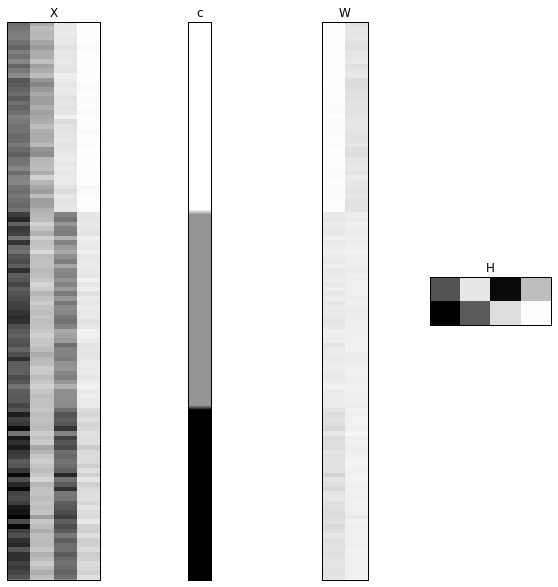

In [19]:
pylab.figure(figsize=(10,10))
pylab.subplot(1, 4, 1)
pylab.title("X")
pylab.imshow(X,  aspect=0.2, cmap=pylab.cm.Greys, interpolation='none'); pylab.xticks([]); pylab.yticks([])

pylab.subplot(1, 4, 2)
pylab.title("c")
pylab.imshow(np.matrix(c).T,  aspect=0.2, cmap=pylab.cm.Greys); pylab.xticks([]); pylab.yticks([])

vmin = min(W.min(), W.min())
vmax = max(W.max(), H.max())

pylab.subplot(1, 4, 3)
pylab.title("W")
pylab.imshow(W, cmap=pylab.cm.Greys, aspect=0.2, vmin=vmin, vmax=vmax, interpolation='none'); pylab.xticks([]); pylab.yticks([])

pylab.subplot(1, 4, 4)
pylab.title("H")
pylab.imshow(H, cmap=pylab.cm.Greys, aspect=0.8, vmin=vmin, vmax=vmax, interpolation='none'); pylab.xticks([]); pylab.yticks([]);

Kateri faktorji so povezani s katerimi atributi?

In [20]:
for i, a in enumerate(data.domain.attributes):
    print "(%s) %s" % (i, a.name)

(0) sepal length
(1) sepal width
(2) petal length
(3) petal width


Izračunajmo aproksimacijo X_apr, razliko do pravega X in vse izrišimo.

In [21]:
X_apr = W.dot(H)
X_dif = abs(X - X_apr)
print "Največja razlika:", X_dif.max()

Največja razlika: 0.560882611475


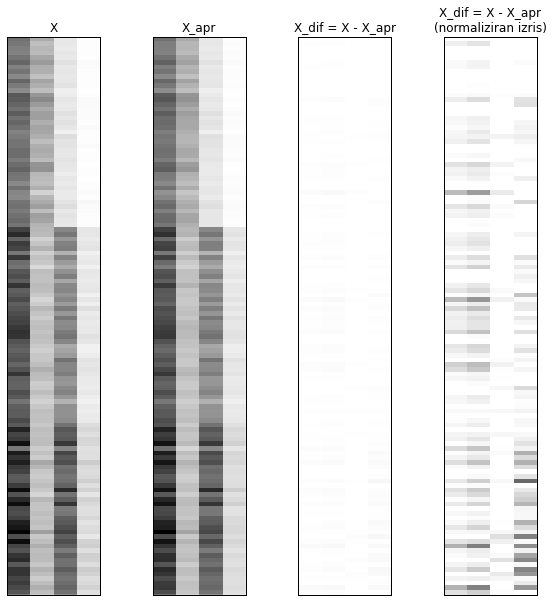

In [22]:
vmin = min(X.min(), X_apr.min())
vmax = max(X.max(), X_apr.max())

pylab.figure(figsize=(10,10))
pylab.subplot(1, 4, 1)
pylab.title("X")
pylab.imshow(X, cmap=pylab.cm.Greys, aspect=0.2, vmin=vmin, vmax=vmax, interpolation='none'); pylab.xticks([]); pylab.yticks([])

pylab.subplot(1, 4, 2)
pylab.title("X_apr")
pylab.imshow(X_apr, cmap=pylab.cm.Greys, aspect=0.2, vmin=vmin, vmax=vmax, interpolation='none'); pylab.xticks([]); pylab.yticks([])

pylab.subplot(1, 4, 3)
pylab.title("X_dif = X - X_apr")
pylab.imshow(X_dif, cmap=pylab.cm.Greys, aspect=0.2, vmin=vmin, vmax=vmax, interpolation='none'); pylab.xticks([]); pylab.yticks([])

pylab.subplot(1, 4, 4)
pylab.title("X_dif = X - X_apr\n(normaliziran izris)")
pylab.imshow(X_dif, cmap=pylab.cm.Greys, aspect=0.2, vmin=vmin, vmax=vmax/10, interpolation='none'); pylab.xticks([]); pylab.yticks([]);

## Izris primerov in atributov v prostoru faktorjev

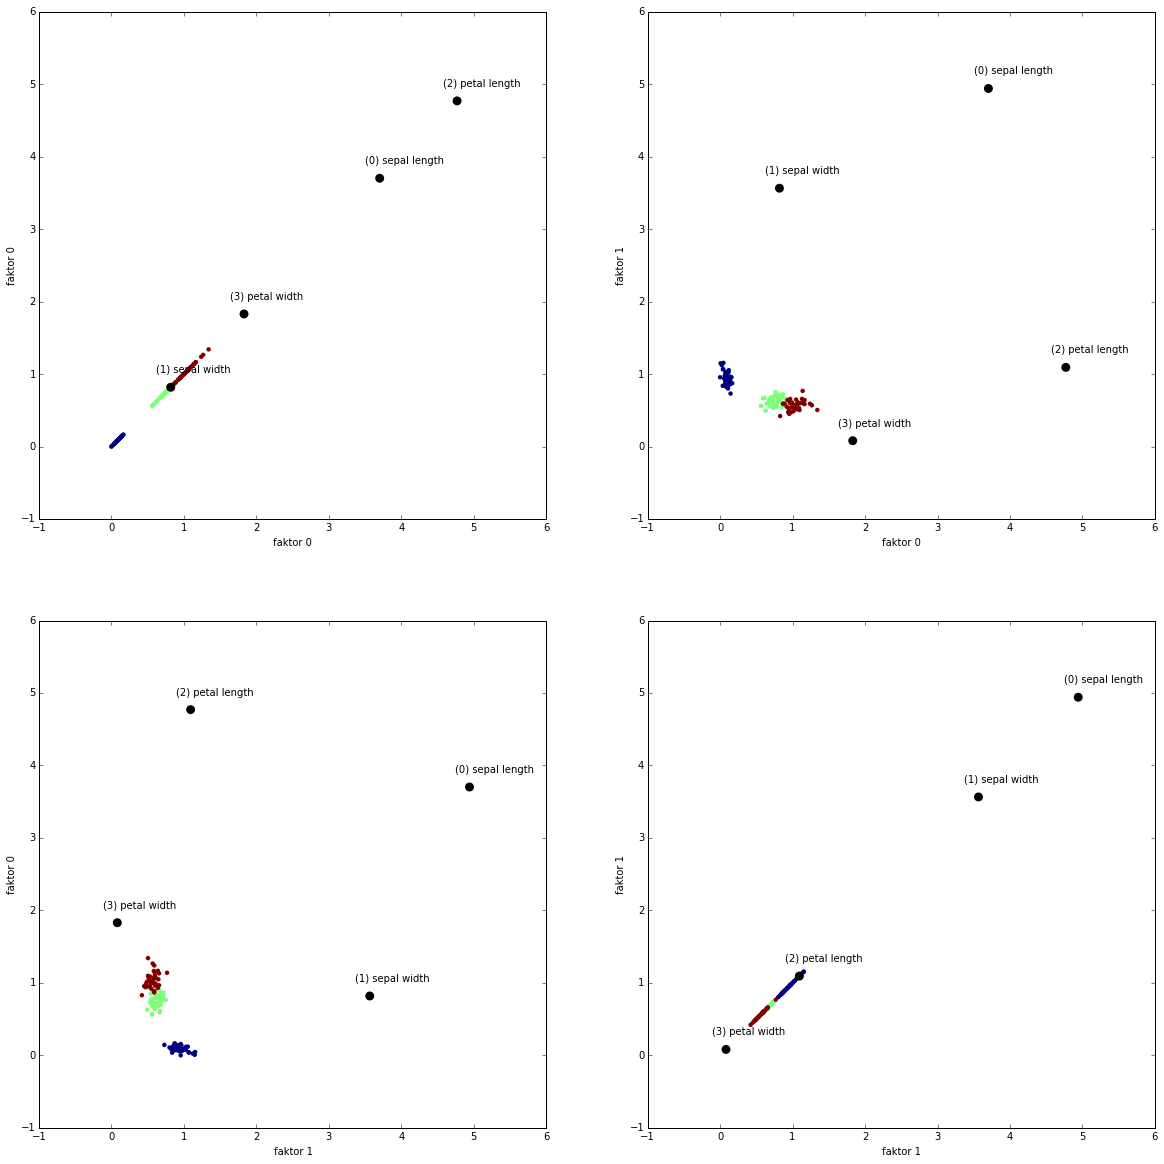

In [23]:
pylab.figure(figsize=(20,20))
for f1 in range(k):
    for f2 in range(k):
        pylab.subplot(k, k, 1+f1*k+f2)
        pylab.scatter(W[:,f1], W[:,f2], c=c, label='primeri', edgecolor='none')
        pylab.scatter(H[f1,:], H[f2,:], c='black', label='atributi', edgecolor='none', s=80.0)
        pylab.xlabel("faktor %s" % f1)
        pylab.ylabel("faktor %s" % f2)
        [pylab.text(x-0.2, y+0.2, "(%s) %s" % (i, data.domain.attributes[i].name)) for i, (x, y) in enumerate(zip(H[f1,:], H[f2,:]))]

Kateri faktorji najboljše ločujejo razrede?<br />
Pozor, razred ni bil uporabljen pri faktorizaciji.

## Faktorji kot novi atributi
Za gradnjo napovednega modela lahko uporabimo aproksimirano matriko, saj naj bi iz nje bil odstranjen "šum".<br />

Napovedni lahko zgradimo iz matrike W, ki primere preslika v prostor faktorjev.

In [24]:
_, p = W.shape  # število atributov
features = [Orange.feature.Continuous("X%i" % (i + 1)) for i in range(p)]
class_var = Orange.feature.Discrete("C", values=data.domain.class_var.values)  # razred
domain = Orange.data.Domain(features, class_var)
data_faktorji = Orange.data.Table(domain, np.column_stack((W, c)))

print data[0]
print data_faktorji[0]

[5.1, 3.5, 1.4, 0.2, 'Iris-setosa']
[0.072, 0.973, 'Iris-setosa']


Izvedimo prečno preverjanje na obeh.

In [25]:
learners = [Orange.classification.bayes.NaiveLearner(),
            Orange.classification.tree.TreeLearner(),
            Orange.classification.knn.kNNLearner(k=3),
            Orange.classification.svm.SVMLearner(),
            Orange.classification.majority.MajorityLearner()]

print "data"
cv = Orange.evaluation.testing.cross_validation(learners, data, folds=5)
for i, score in enumerate(learners):
    print "%10s: CA= %.3f, AUC= %0.3f" % (learners[i].name, Orange.evaluation.scoring.CA(cv)[i], Orange.evaluation.scoring.AUC(cv)[i])
print

print "data_faktorji"
cv = Orange.evaluation.testing.cross_validation(learners, data_faktorji, folds=5)
for i, score in enumerate(learners):
    print "%10s: CA= %.3f, AUC= %0.3f" % (learners[i].name, Orange.evaluation.scoring.CA(cv)[i], Orange.evaluation.scoring.AUC(cv)[i])
print

data
     naive: CA= 0.920, AUC= 0.990
      tree: CA= 0.953, AUC= 0.977
       kNN: CA= 0.960, AUC= 0.985
       sVM: CA= 0.960, AUC= 0.999
  majority: CA= 0.333, AUC= 0.500

data_faktorji
     naive: CA= 0.958, AUC= 0.991
      tree: CA= 0.917, AUC= 0.957
       kNN: CA= 0.925, AUC= 0.988
       sVM: CA= 0.950, AUC= 0.992
  majority: CA= 0.333, AUC= 0.500



# Napovedovanje vrednosti - testni podatki v matriki
Vrednosti v celicah, ki bistveno odstopajo med pravimi podatki in aproksimiranimi, so potencialne nove napovedi.

In [26]:
mis_X = np.copy(X)
mis_X[0,0] = 0 # postavimo na 0
print "trenutna vrednost celice, ki želimo napovedati:", mis_X[0,0]
print "dejanska vrednost:", X[0,0] # dejanska vrednost

trenutna vrednost celice, ki želimo napovedati: 0.0
dejanska vrednost: 5.09999990463


In [27]:
k = 2
W, H = pgdnmf(mis_X, rank=k, max_iter=200)
X_mis_apr = W.dot(H)
print "napovedana vrednost:", X_mis_apr[0,0]

napovedana vrednost: 5.0341782975


Če primerjamo vrednosti aproksimacije in prave vrednosti, hitro odkrijemo "težavne" primere.

In [28]:
W, H = pgdnmf(X, rank=k, max_iter=200)
X_apr = W.dot(H)

X_dif = abs(X - X_apr)
# vrstice (primeri) z največjimi odstopanji
max_dif_rows = sorted([(max(r), ri) for ri, r in enumerate(X_dif)], reverse=True)
for _, ri in max_dif_rows[:5]:
    print "%3s (%s): %s" % (ri, c[ri], X[ri])
    print "           %s" % (X_apr[ri])
    print

 95 (2.0): [ 5.80000019  2.79999995  5.0999999   2.4000001 ]
           [ 5.99685951  2.50503159  5.21308409  1.83920666]

109 (2.0): [ 6.30000019  3.4000001   5.5999999   2.4000001 ]
           [ 6.67604095  2.89836643  5.56963215  1.94278002]

107 (2.0): [ 6.0999999   2.5999999   5.5999999   1.39999998]
           [ 6.16408241  2.57146687  5.36574252  1.89375816]

118 (2.0): [ 6.19999981  3.4000001   5.4000001   2.29999995]
           [ 6.57051669  2.90687168  5.36571763  1.86017971]

114 (2.0): [ 6.69999981  3.29999995  5.69999981  2.5       ]
           [ 6.91071413  2.99593822  5.77460862  2.01518951]



# Napovedovanje vrednosti - novi primer, izven matrike
Nove primere lahko projeciramo v prostor faktorjev, in potem naprej sklepamo o njegovih drugih lastnostih (recimo, razredu ali drugih atributih).

    W = (X * H.T) / (W * H * H.T)

Spomnimo se:
    W je reda (m, k)
    H je reda (k, n)
    
    X je reda (m, n)
    
Torej, v zgornjem izrazu delimo matriki, ki sta reda:

    X * H.T = (m, n) * (n, k) => (m, k)
    W * H * H.T = (m, k) * (k, n) * (n, k) => (m, k)
    
Dimenzije se torej ujemajo z dimenzijami W (m, k).

In [29]:
def nmf_fix(X, H, k, max_iter=100):
    """
    :param X: matrix with descriptions of test examples.
    :param H: matrix for a pre-built model.
    :param k: Factorization rank
    :param max_iter: Max. number of iterations.
    :return:
        W: A predicted row clustering matrix.
    """
    m, N = X.shape
    W = np.random.rand(m, k)

    for itr in range(max_iter):
        enum = X.dot(H.T)
        denom = W.dot(H.dot(H.T))
        W = np.nan_to_num(W * enum/denom)

    return W

In [30]:
W_example = nmf_fix(X[0:2,:], H, k, max_iter=1000)

print W_example
print W[0:2]

[[ 0.95395168  0.06238474]
 [ 0.86011554  0.09837942]]
[[ 0.95434173  0.06191332]
 [ 0.86045634  0.09796664]]


# Hkratna faktorizacija več matrik -> zlivanje podatkov

Osnovni cilj faktorizacije dopolnimo na več matrik X_i, ki jih izrazimo kot produkt dveh matrik nižjega reda (k):

    X_i ~ W * H_i

Pri čemer je:

    X_i reda (m, n_i)

    W reda (m, k)
    H_i reda (k, n_i)
    
Nižji red (k) predstavlja pričakovano število vzorcev v podatkih.
Matrika W je skupna, in preko nje prihaja do "zlivanja" podatkov med matrikami X_i.

## Primer zlivanja podatkov o interakciji protein-RNA

<img src="http://127.0.0.1:8888/notebooks/slike/faktorizacija-zlivanje-shema.png", width=900>